In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split
import pandas as pd
import data_pecarn 
import data_psrc
import data
import util
from style import *
from collections import Counter
from data import feats_numerical, feats_categorical, meta, outcome_def
# plt.style.use('dark_background')
# sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2

**load the data**

In [18]:
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=False, impute=True)
feats_binary = [feat for feat in common_feats
                if not feat in feats_numerical + feats_categorical + meta]
# df_pecarn = df_pecarn[df_pecarn.cv_fold.isin(data.pecarn_train_idxs)]
# df_psrc = df_psrc[df_psrc.cv_fold.isin(data.psrc_train_idxs)]

computing pecarn preprocessing...
computing psrc preprocessing...


# see what feats matched / are missing

In [ ]:
# matched feats
for feat in common_feats:
    print(feat, '\t', df_pecarn[feat].min(), '\t', df_pecarn[feat].max())
print(list(filtered_feats_pecarn.intersection(filtered_feats_psrc)))

In [ ]:
print('psrc but not pecarn')
filtered_feats_psrc.difference(filtered_feats_pecarn)

In [10]:
print('pecarn but not psrc')
print(filtered_feats_pecarn.difference(filtered_feats_psrc))

pecarn but not psrc
{'Sex', 'ThoracicTender'}


# look for feat shift

**continuous features**

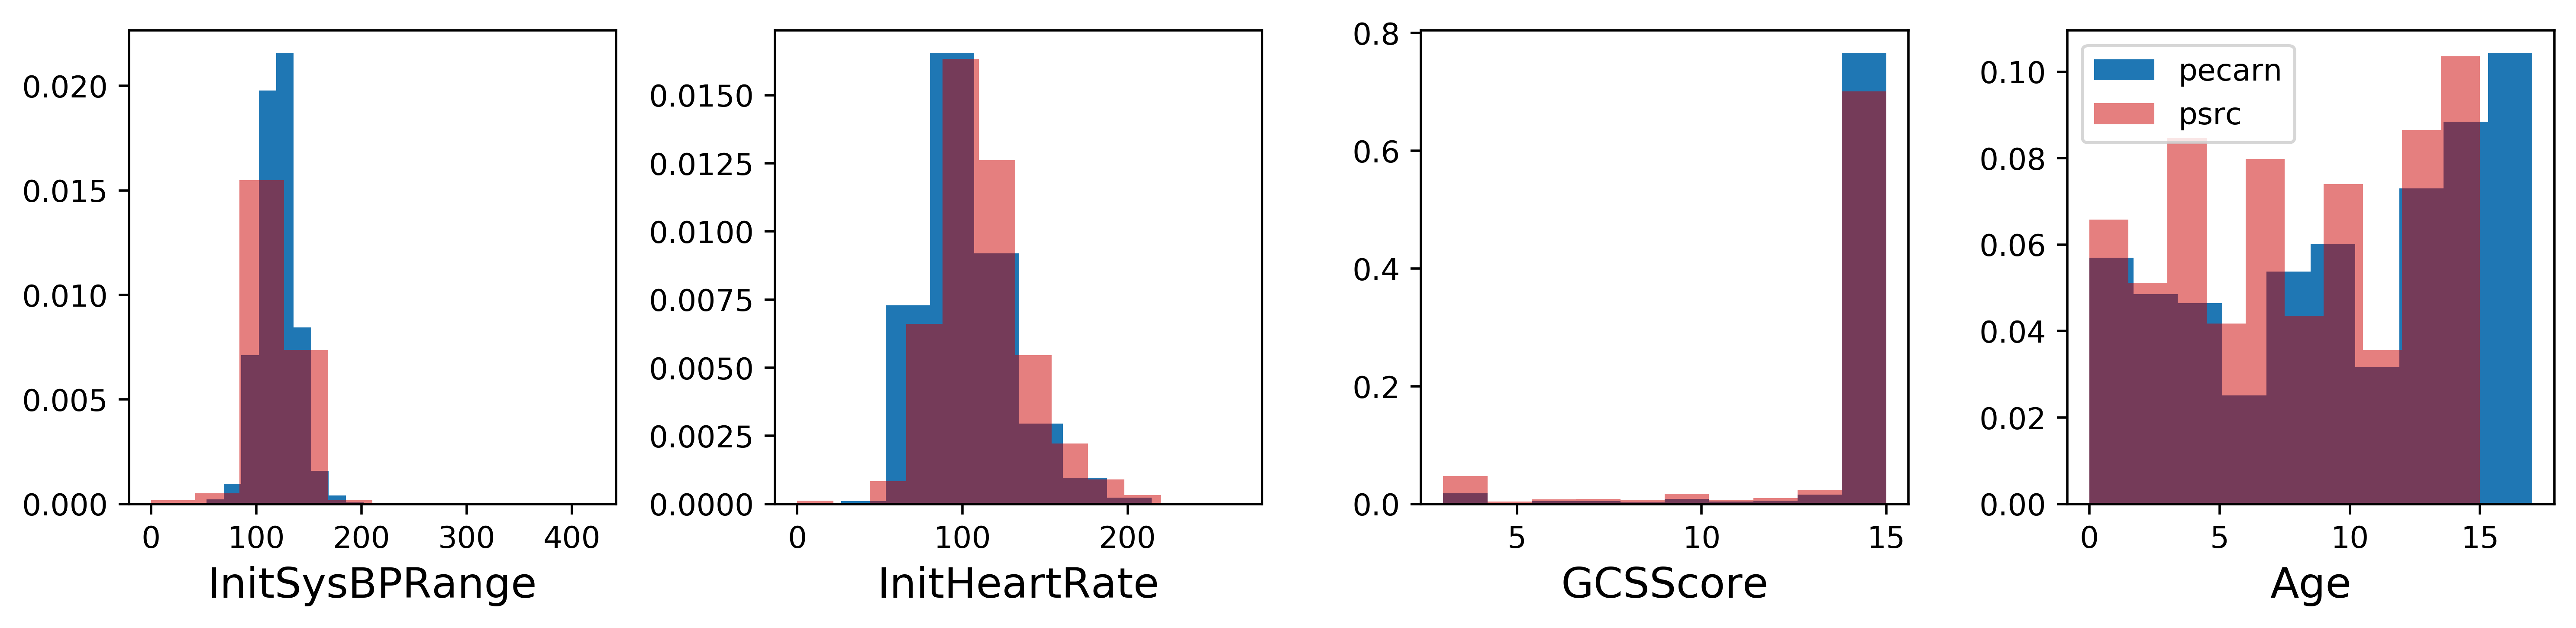

In [14]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(df_pecarn[feat], density=True, alpha=1, label='pecarn', color=cb)
    plt.hist(df_psrc[feat], density=True, alpha=0.5, label='psrc', color=cr)
    plt.xlabel(feat, fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

**categorical features**

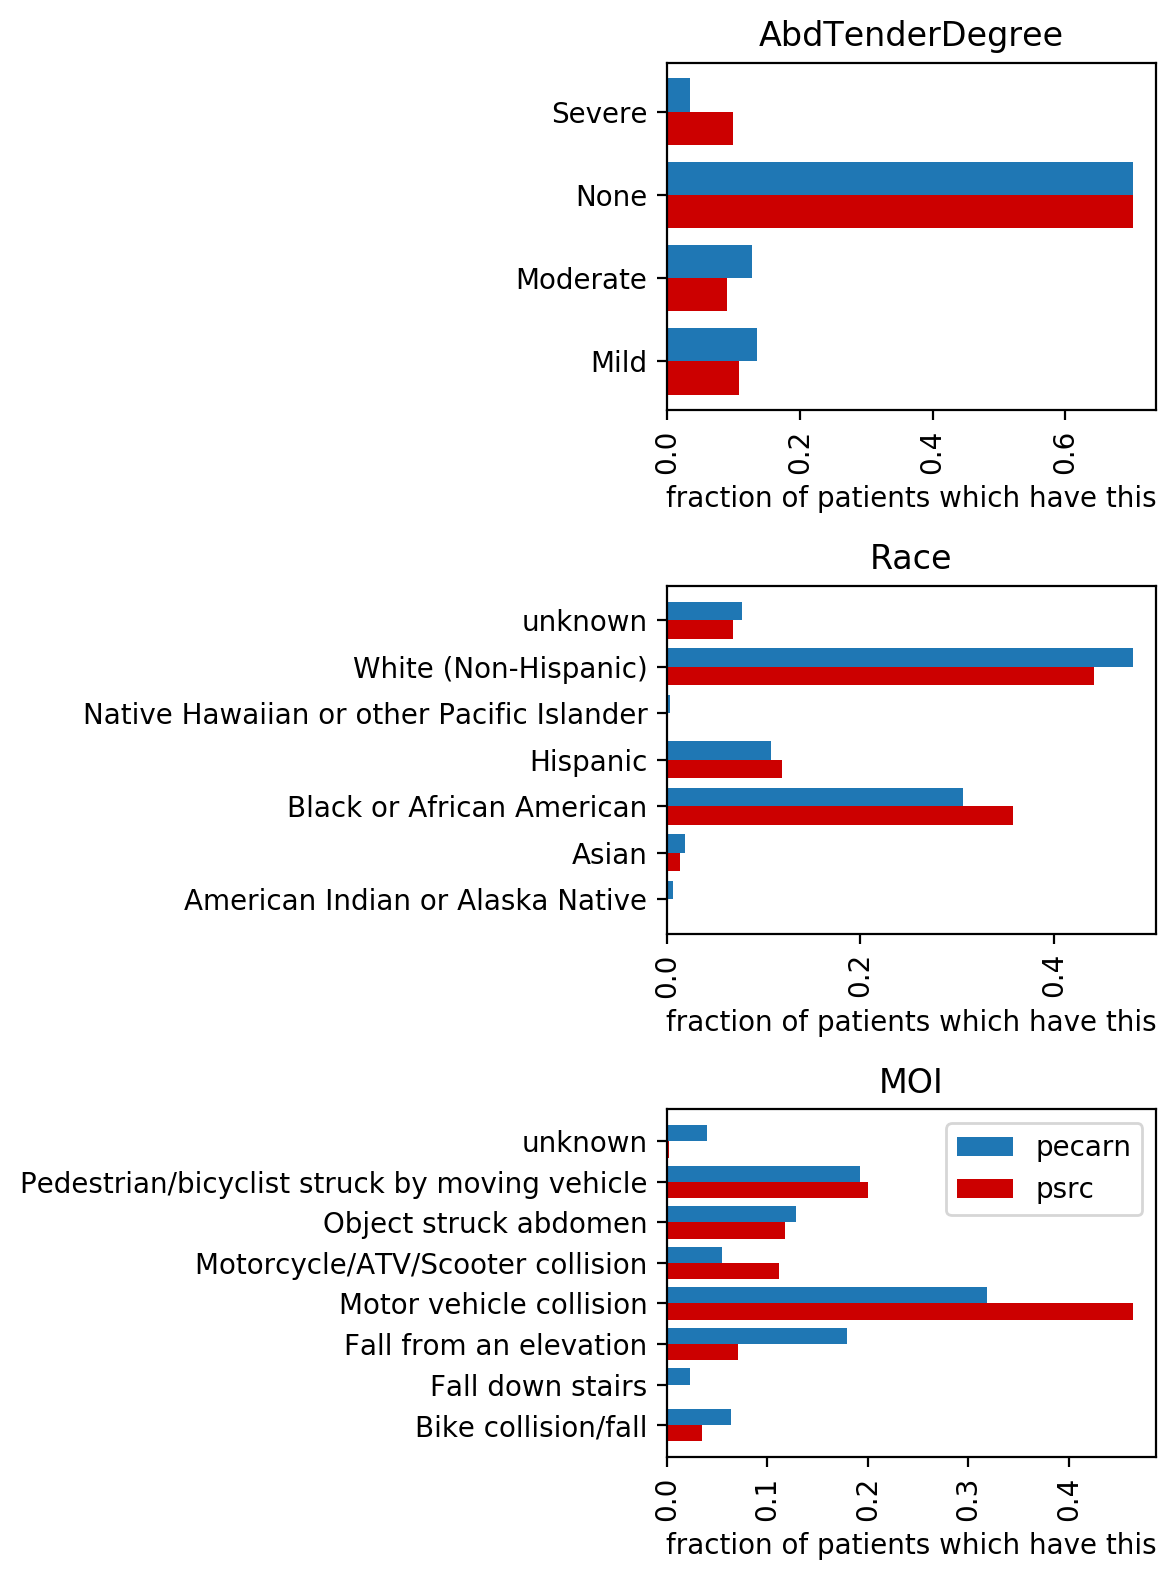

In [19]:
R, C = len(feats_categorical), 1
plt.figure(figsize=(6, 8), dpi=200)
# print(feats_categorical)
for i in range(R):
    plt.subplot(R, C, i + 1)
    feat = feats_categorical[i]
    vals_unique = np.unique(np.hstack((df_pecarn[feat], df_psrc[feat]))).tolist()
    n = len(vals_unique)
    frac_pecarn = np.array([(df_pecarn[feat]==val).sum() for val in vals_unique]) / df_pecarn.shape[0]
    frac_psrc = np.array([(df_psrc[feat]==val).sum() for val in vals_unique]) / df_psrc.shape[0]
    
    width = 0.4
    plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
    plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
    plt.yticks(np.arange(n) - width + 0.2, vals_unique)
    plt.xlabel('fraction of patients which have this')

    plt.xticks(rotation='vertical')
    plt.title(feat)

plt.legend()
plt.tight_layout()
plt.show()

**binary feats**

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


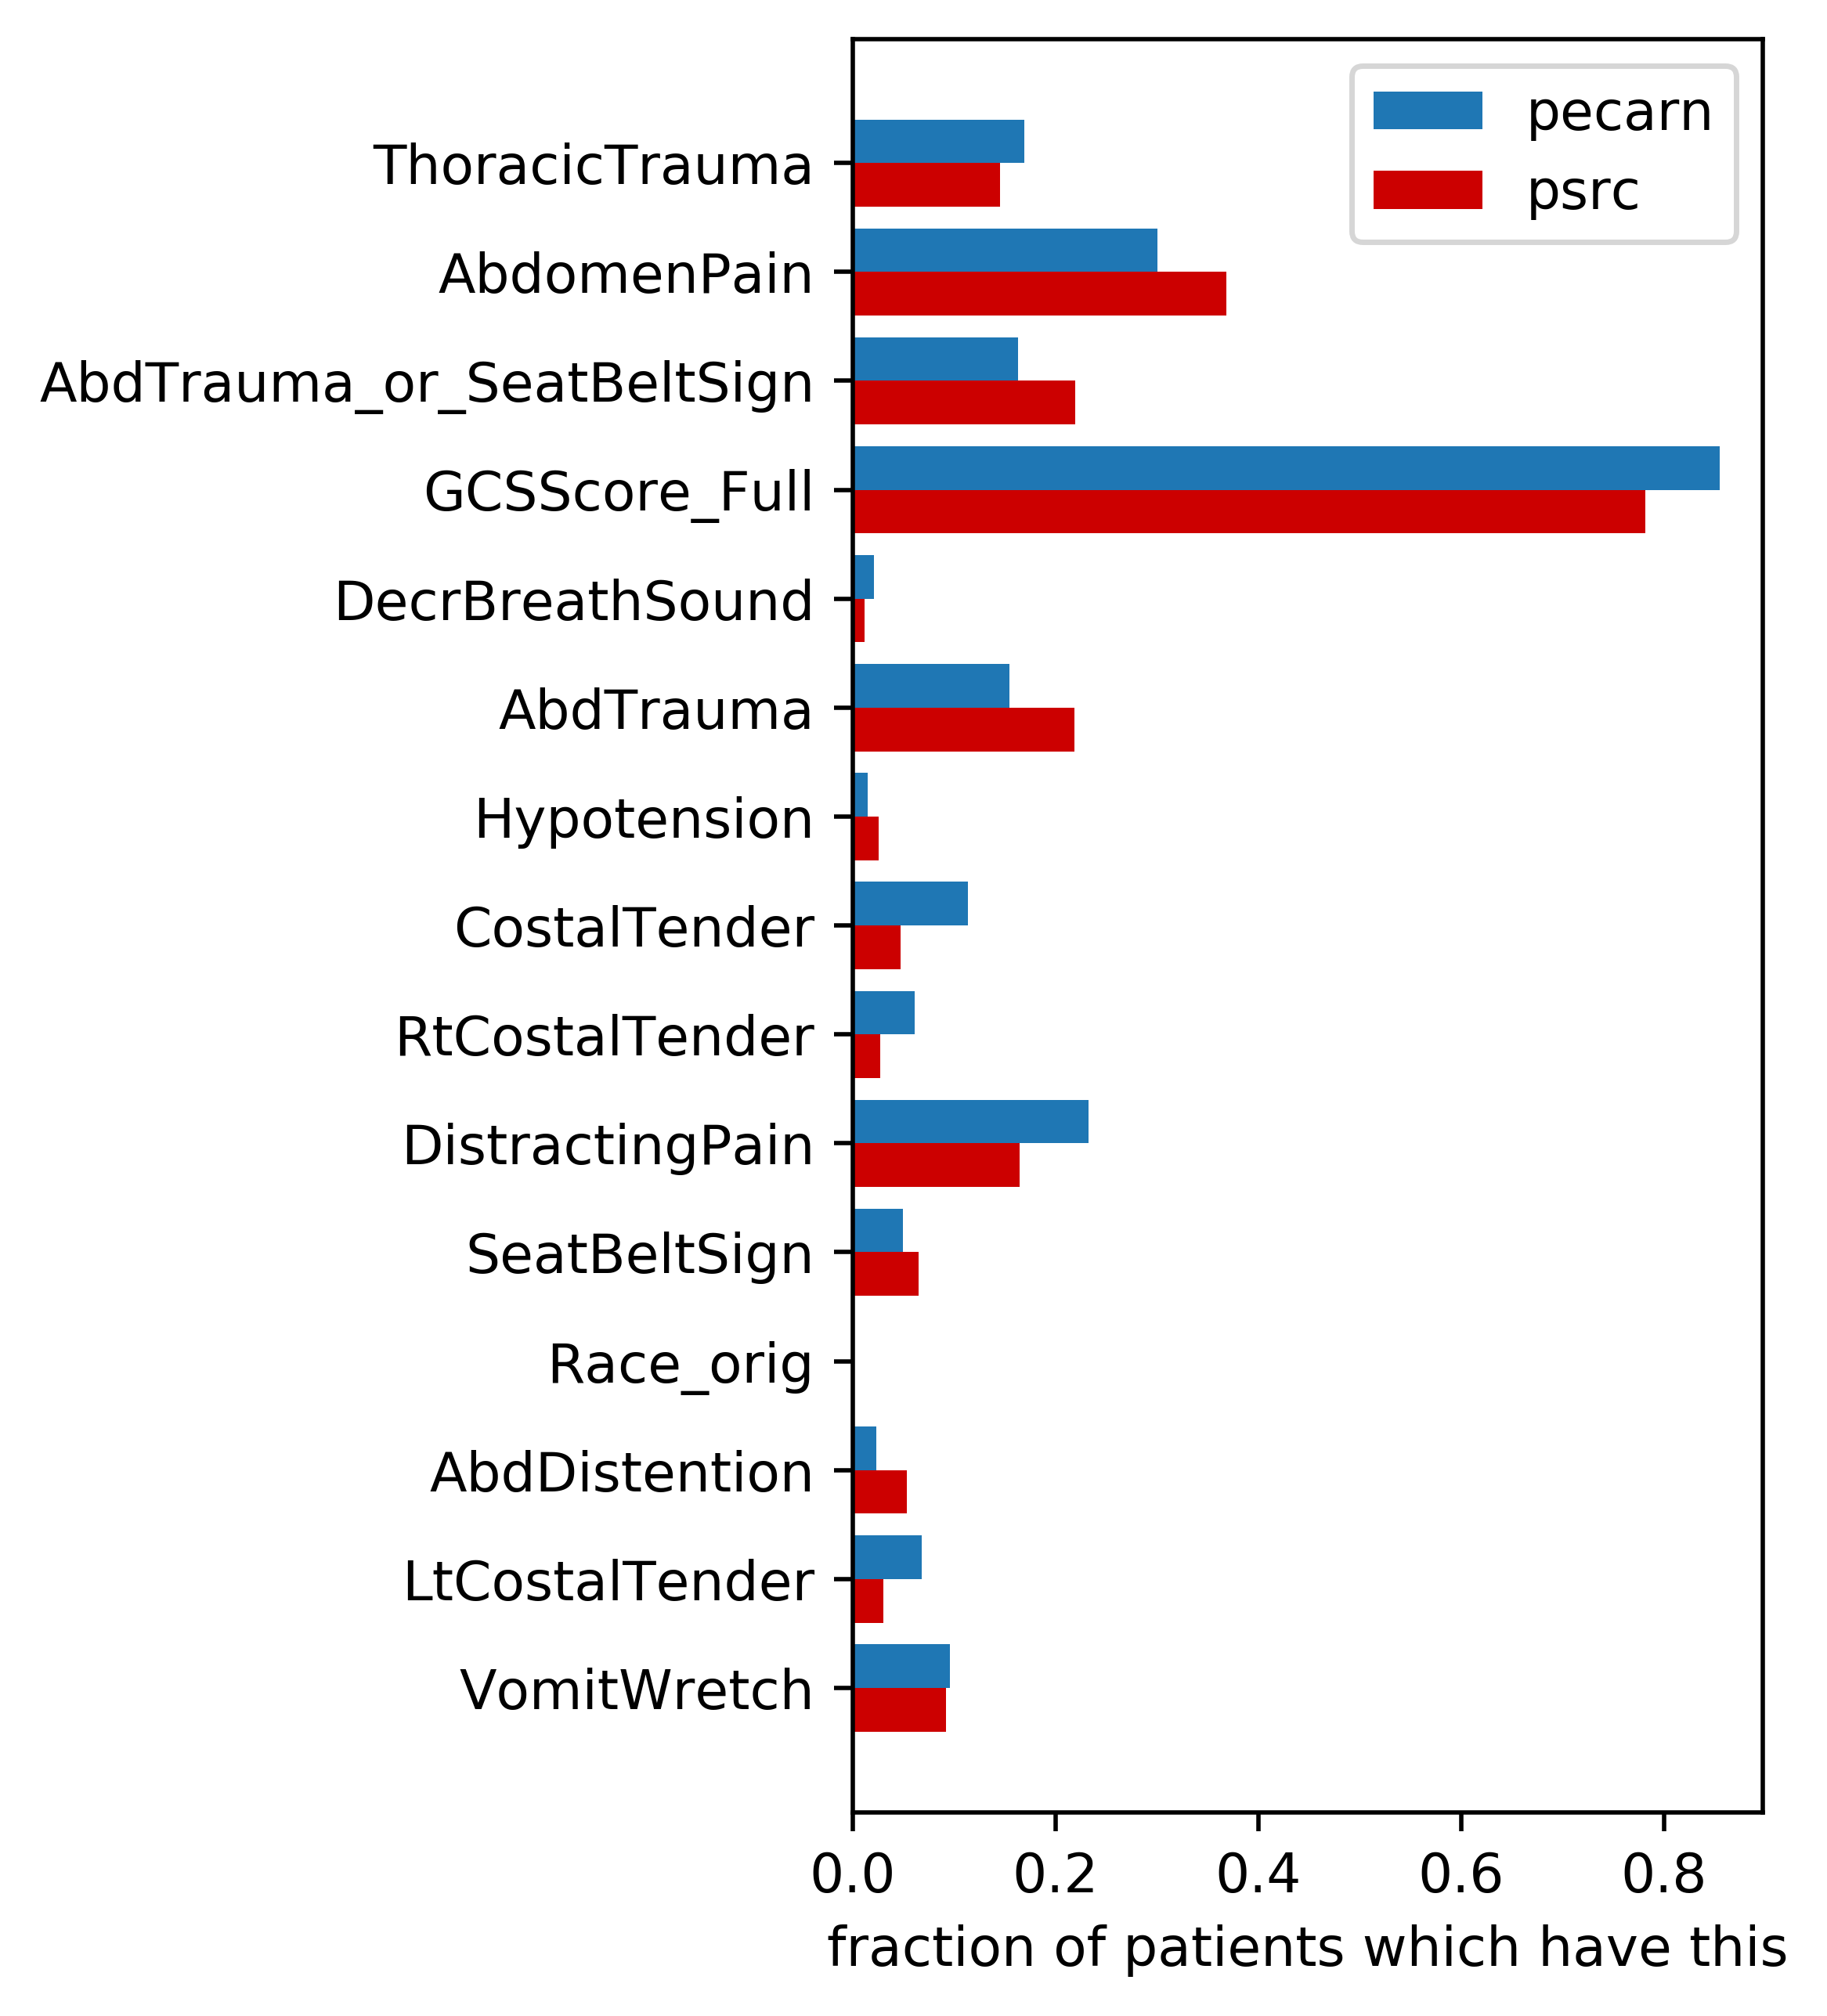

In [20]:
R, C = 3, 4
n = len(feats_binary)
def true_or_yes(vals):
    return (vals==True) | (vals=='yes')
frac_psrc = true_or_yes(df_psrc[feats_binary]).mean().values
frac_pecarn = true_or_yes(df_pecarn[feats_binary]).mean().values

width = 0.4
plt.figure(dpi=500, figsize=(3, 6))
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
plt.yticks(np.arange(n) - width + 0.2, feats_binary)
plt.xlabel('fraction of patients which have this')
plt.legend()
plt.show()

**missing features**

In [ ]:
R, C = 3, 4
feats_all = [feat for feat in common_feats
         if not feat in meta]
n = len(feats_all)
frac_psrc = (df_psrc[feats_all]=='unknown').mean().values
frac_pecarn = (df_pecarn[feats_all]=='unknown').mean().values

width = 0.4
plt.figure(dpi=300, figsize=(3, 6))
plt.xlabel('Fraction of patients\nmissing this feature')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
plt.yticks(np.arange(n) - width + 0.2, feats_all)

plt.legend()
plt.show()

**write csvs**

In [23]:
df_pecarn.astype('object').describe().transpose().to_csv('processed/pecarn_vars.csv')
df_psrc.astype('object').describe().transpose().to_csv('processed/psrc_vars.csv')

# how are vars related to outcome

In [3]:
def get_risks(df, feat, vals_unique, outcome='iai_intervention'):
    '''Return iai with intervention as a percentage
    '''
    risks = []
    for val in vals_unique:
        risks.append(df[df[feat]==val][outcome].mean())
    return np.array(risks) * 100

In [ ]:
# feats = feats_categorical
feats = ['Sex', 'Age_discrete']


def agecut(age): # inclusive on right end
    return pd.cut(age, bins=(-1, 4, 9, 1000), labels=['<5', '5-9', '>9'])
df_psrc['Age_discrete'] = agecut(df_psrc['Age'])
df_pecarn['Age_discrete'] = agecut(df_pecarn['Age'])

R, C = len(feats), 1
plt.figure(figsize=(6, 8), dpi=200)
WIDTH = 0.4
for i in range(R):
    plt.subplot(R, C, i + 1)
    feat = feats[i]
    if feat in df_psrc.keys(): # need to check bc Sex is not there
        vals_unique = list(set(df_pecarn[feat].unique().tolist() + df_psrc[feat].unique().tolist()))
        n = len(vals_unique)
        risks = get_risks(df_psrc, feat, vals_unique)
        plt.barh(np.arange(n) - WIDTH, risks, height=0.4, label='psrc', color=cg) #, color=cr)
    else:
        vals_unique = np.unique(df_pecarn[feat]).tolist()
        n = len(vals_unique)
    
    risks = get_risks(df_pecarn, feat, vals_unique)
    plt.barh(np.arange(n), risks, height=0.4, label='pecarn', color=cp) #, color=cb)
    plt.yticks(np.arange(n) - WIDTH + 0.2, vals_unique)
    plt.xlabel('Risk for IAIw/I (%)')

    plt.xticks(rotation='vertical')
    plt.title(feat)

plt.legend()
plt.tight_layout()
plt.show()